# LOFAR OPC UA single station imaging

In [1]:
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from lofarantpos.db import LofarAntennaDatabase

In [3]:
from lofarimaging import make_xst_plots

In [4]:
from lofarimaging.opc_interface import download_xst

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
station_name = "RS210"
subband = 250
integration_time_s = 2

In [7]:
db = LofarAntennaDatabase()

In [8]:
%time obstime, visibilities, rcu_mode = download_xst(subband, integration_time_s)
rcu_mode

CPU times: user 27.1 ms, sys: 7.83 ms, total: 35 ms
Wall time: 7.07 s


1

In [9]:
obstime

datetime.datetime(2020, 3, 24, 10, 25, 11, 71789)

In [10]:
# HACK to be able to test when station is off
if rcu_mode == 0:
    print("Station is in mode 0, pretending it's in mode 3 to test")
    rcu_mode = 3

In [11]:
sky_fig, ground_fig, leaflet_map = make_xst_plots(visibilities, station_name, obstime, subband, rcu_mode)

Maximum at 48m east, -14m north of station center (lat/long 52.33076, 6.87428)


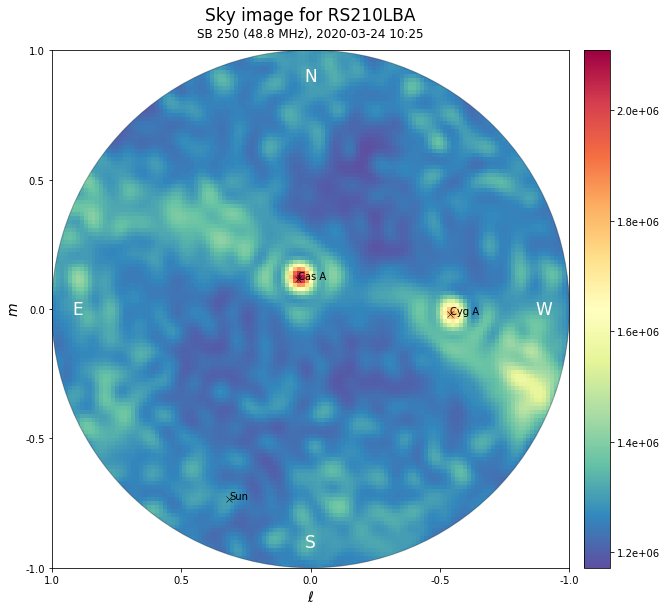

In [12]:
sky_fig

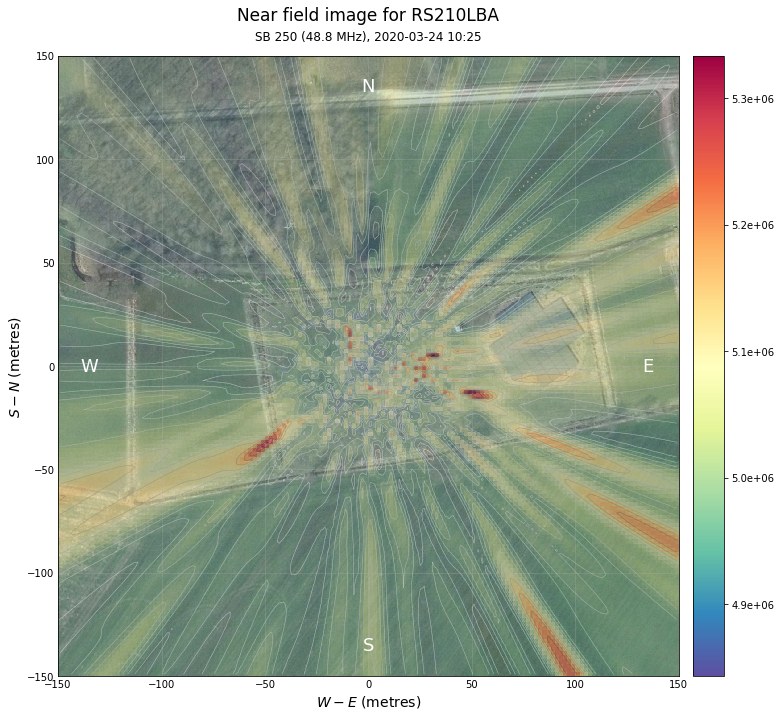

In [13]:
ground_fig

In [14]:
leaflet_map